In [1]:
from scipy.stats import laplace, norm
import numpy as np
import matplotlib.pyplot as plt

from discrepancies import MaximumMeanDiscrepancy
from kernels import (
    PolynomialKernel,
    GaussianKernel,
    LaplacianKernel,
    InverseMultiQuadraticKernel,
)

In [2]:
np.random.seed(0)

# Maximum Mean Discrepancy

The Maximum Mean Discrepancy (MMD) is given by:

$$MMD = \sup_{f\in F} \{ \int f(x) d \mathbb{P}(x)-\int f(y) d \mathbb{Q}(y) \}$$

where $F:= \{||f||_H \leq 1 \}$.

It can be shown that:

$$MMD^2 =  \mathbb{E}_{X, \tilde{X} \sim \mathbb{P}}[k(X,\tilde{X})]-2\mathbb{E}_{X \sim \mathbb{P},Y \sim \mathbb{Q}}[k(X,Y)]+\mathbb{E}_{Y, \tilde{Y} \sim \mathbb{Q}}[k(Y,\tilde{Y})]$$

where $k$ is a kernel function.

An unbiased estimate of MMD:
$$\hat{MMD}^2 = \frac{1}{m(m-1)}\sum_{i=1}^{m}\sum_{j\neq i}^{m}k(x_i, x_j)+\frac{1}{n(n-1)}\sum_{i=1}^{n}\sum_{j\neq i}^{n}k(y_i, y_j)-\frac{2}{mn}\sum_{i=1}^{m}\sum_{j=1}^{n}k(x_i, y_j)$$

# Polynomial Kernels

Here we compare samples from normal distributions of the same mean but different covariances. We can see that for kernels of degree one, the MMD values do not change significantly despite the distributions being compared having different variances.  This is because a linear kernel retains only the first moments of the distributions. However, as we increase the degree of the polynomial kernel, higher moments of the distribution are retained by the kernel mean embedding, and the differences in covariances is reflected in the MMD.

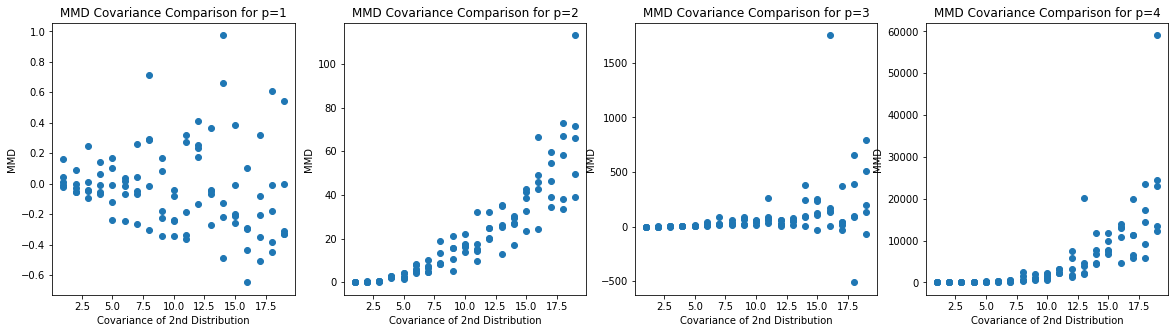

In [3]:
n_dimensions = 5
n_samples = 25
n_trials = 5
sigma = 0.1
m, n = 30, 30
n_polynomials = 4
covariance_scales = np.arange(1, 20)

mu_x = np.zeros(n_dimensions)
covariance_x = np.eye(n_dimensions)
mu_y = np.zeros(n_dimensions)

fig, axs = plt.subplots(1, n_polynomials)
fig.set_figheight(5)
fig.set_figwidth(20)

for i, p in enumerate(np.arange(1, n_polynomials + 1)):
    X, MMDs = [], []
    mmd = MaximumMeanDiscrepancy(kernel=PolynomialKernel(p))
    for covariance_scale in covariance_scales:
        covariance_y = covariance_scale * np.eye(n_dimensions)
        X.extend([covariance_scale] * n_trials)
        MMDs.extend(
            [
                mmd.compute(
                    x=np.random.multivariate_normal(mu_x, covariance_x, n_samples),
                    y=np.random.multivariate_normal(mu_y, covariance_y, n_samples),
                )
                for _ in range(n_trials)
            ]
        )
    axs[i].scatter(X, MMDs)
    axs[i].set_title(f"MMD Covariance Comparison for p={p}")
    axs[i].set_xlabel("Covariance of 2nd Distribution")
    axs[i].set_ylabel("MMD")

On the other hand, when shifting the mean of the distribution, all polynomial kernels will pick this up as this shift changes the first moment of the distribution. 

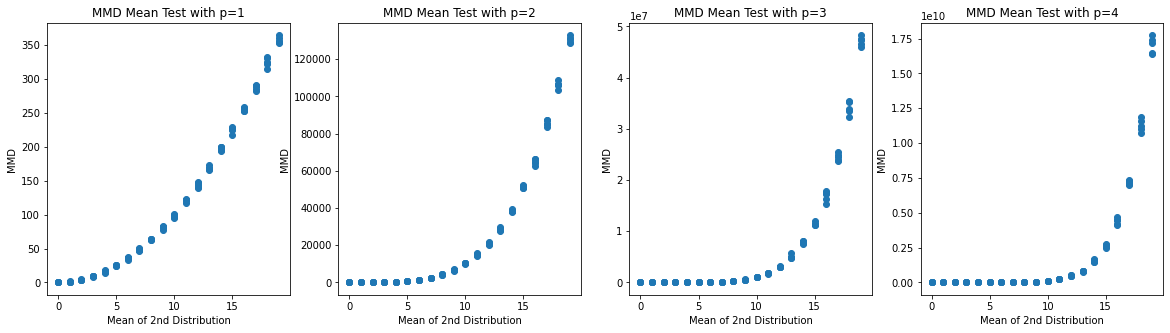

In [4]:
n_dimensions = 5
n_samples = 25
n_trials = 5
sigma = 0.1
m, n = 30, 30
n_polynomials = 4
mu_shifts = np.arange(0, 20)

mu_x = np.zeros(n_dimensions)
covariance_x = np.eye(n_dimensions)
covariance_y = np.eye(n_dimensions)

fig, axs = plt.subplots(1, n_polynomials)
fig.set_figwidth(20)
fig.set_figheight(5)
for i, p in enumerate(np.arange(1, n_polynomials + 1)):
    X, MMDs = [], []
    mmd = MaximumMeanDiscrepancy(kernel=PolynomialKernel(p))
    for mu_shift in mu_shifts:
        mu_y = np.zeros(n_dimensions) + mu_shift
        X.extend([mu_shift] * n_trials)
        MMDs.extend(
            [
                mmd.compute(
                    x=np.random.multivariate_normal(mu_x, covariance_x, n_samples),
                    y=np.random.multivariate_normal(mu_y, covariance_y, n_samples),
                )
                for _ in range(n_trials)
            ]
        )
    axs[i].scatter(X, MMDs)
    axs[i].set_title(f"MMD Mean Test with p={p}")
    axs[i].set_xlabel("Mean of 2nd Distribution")
    axs[i].set_ylabel("MMD")

This motivates the intuition for using an exponential type kernel, which when decomposed, is the power series. By incoporating all possible moments of the signal (distribution), the kernel can be interpreted as a transformation into the Fourier domain. As a Fourier type transform, this also ensures that the kernel is injective (i.e. there is no information loss), maintaining the property $k(X,Y)=0 \Leftrightarrow X = Y$.

# Convergence of $\hat{MMD}$

The emirical MMD is described to converge at a rate of $\mathcal{O}(n^{-1/2})$. By increasing the number of samples taken from two Gaussian distributions, we can see this in action. Because the MMD will be compared between two sets of samples from the same normal distribution, we know that the actual MMD is zero. Thus the absolute value of the empirical MMD can be taken directly as the discrepancy $e = |\hat{MMD}-MMD| = |\hat{MMD}|$. To plot an upper bound line for $\mathcal{O}(n^{-1/2})$, 3 standard deviations are taken for the set of empirical MMD values for 2 sample points to scale the $n^{-1/2}$ function. 

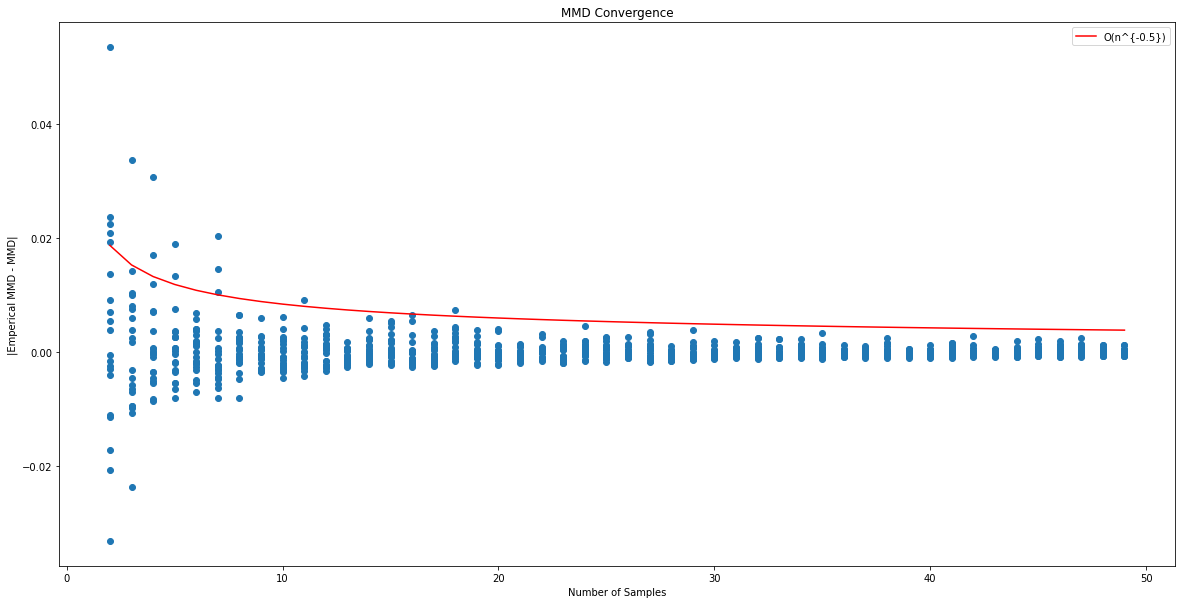

In [5]:
n_dimensions = 3
sigma = 1e-2
mu = np.zeros(n_dimensions)
n_trials = 20
X = []
MMDs = []
max_n_sample = 50
mmd = MaximumMeanDiscrepancy(kernel=LaplacianKernel(sigma))
for n_sample in range(2, max_n_sample):
    X.extend([n_sample] * n_trials)
    MMDs.extend(
        [
            mmd.compute(
                x=np.random.multivariate_normal(
                    mu, np.eye(n_dimensions, n_dimensions), n_sample
                ),
                y=np.random.multivariate_normal(
                    mu, np.eye(n_dimensions, n_dimensions), n_sample
                ),
            )
            for _ in range(n_trials)
        ]
    )

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
fig.set_figwidth(20)
fig.set_figheight(10)

bound_x = np.arange(2, max_n_sample)
ax.plot(
    bound_x,
    np.std(MMDs[:n_trials]) * np.sqrt(2) / np.sqrt(bound_x),
    "r",
    label="O(n^{-0.5})",
)
plt.scatter(X, MMDs)

ax.set_title(f"MMD Convergence")
ax.set_xlabel("Number of Samples")
ax.set_ylabel("|Emperical MMD - MMD|")
ax.legend()
plt.show()

We can see qualitatively see that this suggests that  $\mathcal{O}(n^{-1/2})$ is a reasonable bound for the empirical MMD.

# MNIST Dataset Example

The MMD can be used on data for which the data generating distribution is unknown. As an example, we can use the MNIST dataset to compare images from the same digit as if they are "samples" from the same underlying distribution for that digit. 

In [6]:
from sklearn.datasets import fetch_openml

In [7]:
mnist = fetch_openml("mnist_784")
x = np.array(mnist.data)
y = mnist.target

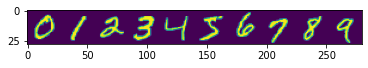

In [8]:
plt.imshow(
    np.stack(
        [x[y == str(i)][0, :].reshape((28, 28)) for i in range(10)], axis=1
    ).reshape((28, 28 * 10))
)
plt.show()

We can visualise a heatmap of the MMDs for samples from different digits. 

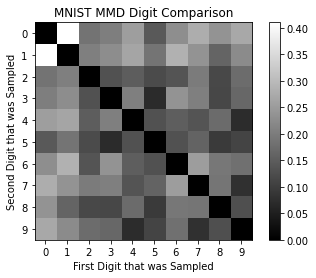

In [9]:
mnist_mmd_gauss = np.zeros((10, 10))
n_samples = 100
sigma = 1e-7
mmd = MaximumMeanDiscrepancy(kernel=GaussianKernel(sigma))
for i in range(10):
    a = x[y == str(i)][:n_samples]
    for j in range(10):
        if i == j:
            b = x[y == str(j)][n_samples : 2 * n_samples]
        else:
            b = x[y == str(j)][:n_samples]
            mnist_mmd_gauss[i, j] = mmd.compute(a, b)

fig, ax = plt.subplots(1, 1)
plt.imshow(mnist_mmd_gauss, cmap="gray")
ax.set_title(f"MNIST MMD Digit Comparison")
ax.set_xlabel("First Digit that was Sampled")
ax.set_ylabel("Second Digit that was Sampled")
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
plt.colorbar()
plt.show()

Samples from the same digit have much lower MMDs (the diagonal). We can see higher MMDs when comparing digits that are not as similar when written, such as 0 and 1. On the hand, more similar digits like 7 and 9 have lower MMDs.

# Witness Functions

Recall that the Maximum Mean Discrepancy (MMD) is given by:

$$MMD = \sup_{f\in F} \{ \int f(x) d \mathbb{P}(x)-\int f(y) d \mathbb{Q}(y) \}$$

where $F:= \{||f||_H \leq 1 \}$.

For this section, we are interested in the function $f$ which maximises $\int f(x) d \mathbb{P}(x)-\int f(y) d \mathbb{Q}(y)$ or in other words, the function chosen by the supremum. This function is known as the witness function.

The witness function $f^*$ can expressed:

$$f^*(t) \propto \langle \phi(t), \mu_p - \mu_q\rangle_H = \mathbb{E}_x[k(x, t)]-\mathbb{E}_y[k(y, t)]$$

We can estimate this function with:

$$\hat{f}^*(t) \propto \langle \phi(t), \mu_p - \mu_q\rangle_H = \frac{1}{m}\sum_{i=1}^{m}k(x_i, t)-\frac{1}{n}\sum_{i=1}^{n} k(y_i, t)$$

We can plot the witness function for the MMD betwee Gaussian and Laplace Distributions:

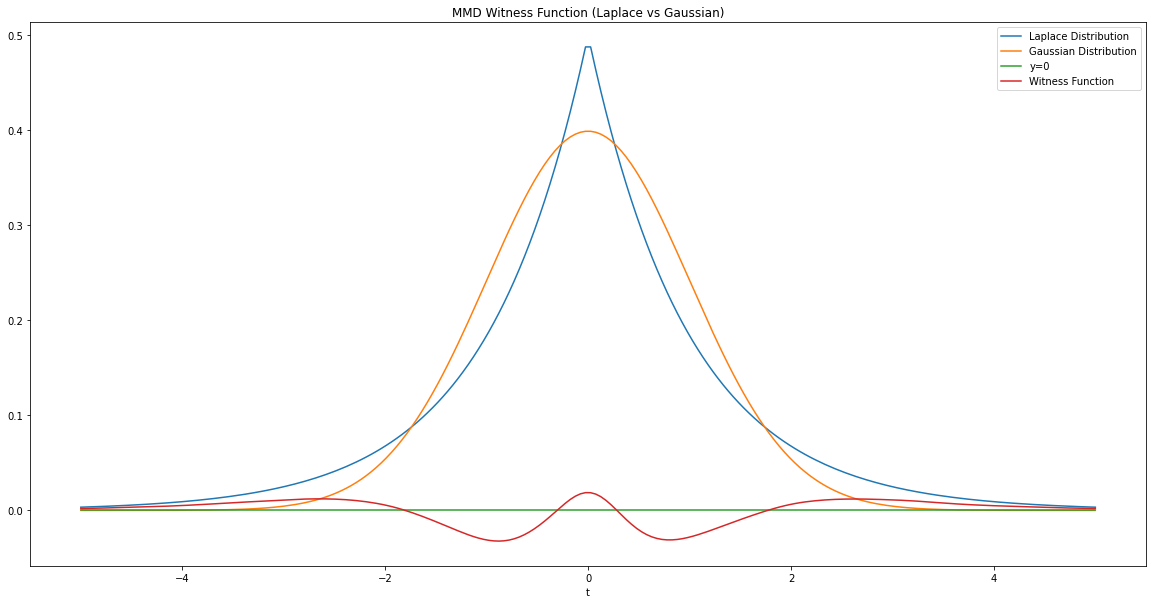

In [10]:
fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(10)

n_p1_samples = int(1e5)
n_p2_samples = int(1e5)
p1_samples = np.random.laplace(loc=0.0, scale=1.0, size=n_p1_samples)
p2_samples = np.random.normal(loc=0.0, scale=1.0, size=n_p1_samples)
t = np.linspace(-5, 5, 200)
sigma = 10
mmd = MaximumMeanDiscrepancy(kernel=GaussianKernel(sigma))
witness_values = mmd.witness_function(p1_samples, p2_samples, t)
plt.plot(t, laplace.pdf(t), label="Laplace Distribution")
plt.plot(t, norm.pdf(t), label="Gaussian Distribution")
plt.plot(t, np.zeros(t.shape), label="y=0")
plt.plot(t, witness_values, label="Witness Function")
plt.title("MMD Witness Function (Laplace vs Gaussian)")
plt.xlabel("t")
plt.legend()
plt.show()

The quality of the witness function approximation can depend quite sigificantly on the number of samples availble. Here we show the witness function converging as we increase the number of samples from both distributions.

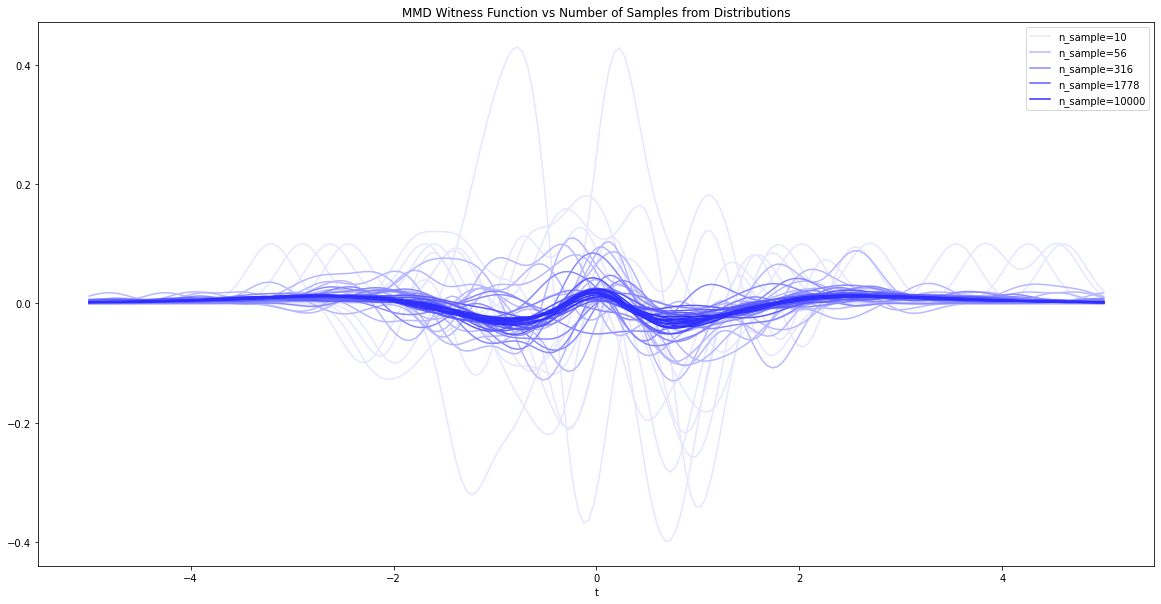

In [11]:
n_trials = 10
n_samples = np.logspace(1, 4, 5).astype(int)
fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(10)
sigma = 10
t = np.linspace(-5, 5, 200)
mmd = MaximumMeanDiscrepancy(kernel=GaussianKernel(sigma))
for i, n_sample in enumerate(n_samples):
    for j in range(n_trials):
        witness_values = mmd.witness_function(
            x=np.random.laplace(loc=0.0, scale=1.0, size=n_sample),
            y=np.random.normal(loc=0.0, scale=1.0, size=n_sample),
            t=t,
        )
        shade = 0.9 * (len(n_samples) - i) / len(n_samples)
        if j == 0:
            plt.plot(
                t,
                witness_values,
                c=(shade, shade, 1),
                label=f"{n_sample=}",
            )
        else:
            plt.plot(t, witness_values, c=(shade, shade, 1))
plt.title("MMD Witness Function vs Number of Samples from Distributions")
plt.xlabel("t")
plt.legend()
plt.show()

We can also see how the kernel parameters can influence the shape of the witness function.

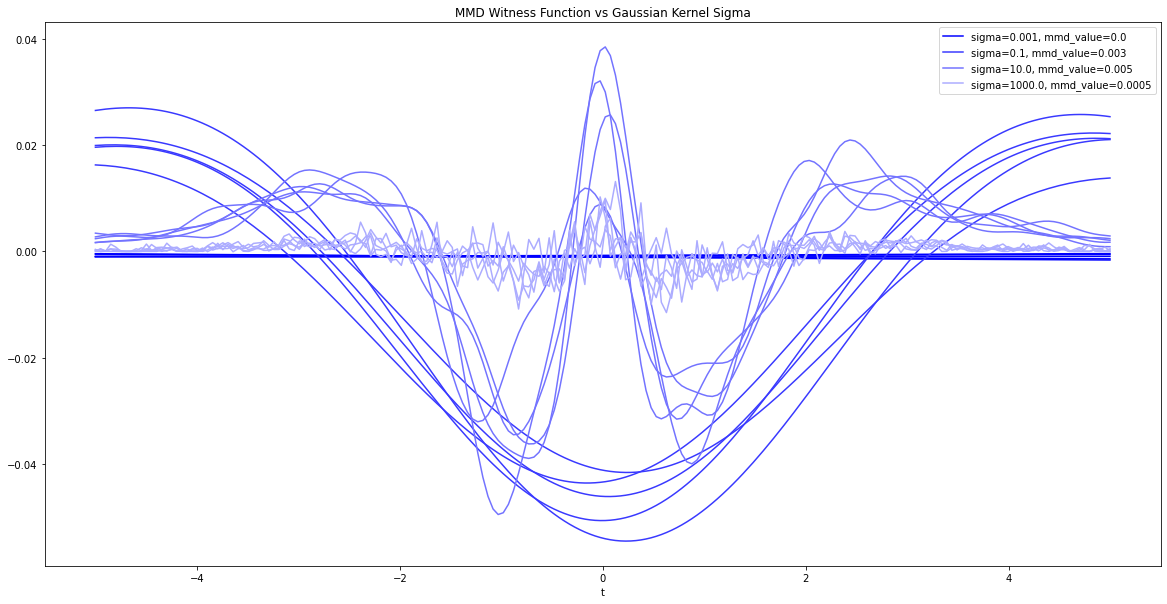

In [12]:
n_trials = 5
sigmas = np.round(np.logspace(-3, 3, 4), 4)
fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(10)
n_sample = int(2e3)
t = np.linspace(-5, 5, 200)
for i, sigma in enumerate(sigmas):
    mmd = MaximumMeanDiscrepancy(kernel=GaussianKernel(sigma))
    for j in range(n_trials):
        x = np.random.laplace(loc=0.0, scale=1.0, size=n_sample)
        y = np.random.normal(loc=0.0, scale=1.0, size=n_sample)
        witness_values = mmd.witness_function(
            x=x,
            y=y,
            t=t,
        )
        shade = 0.9 * i / len(sigmas)
        c = (shade, shade, 1)
        if j == 0:
            mmd_value = np.round(float(mmd.compute(x, y)), 4)
            plt.plot(
                t,
                witness_values,
                c=c,
                label=f"{sigma=}, {mmd_value=}",
            )
        else:
            plt.plot(t, witness_values, c=c)
plt.title("MMD Witness Function vs Gaussian Kernel Sigma")
plt.xlabel("t")
plt.legend()
plt.show()

It can be seen that certain sigma values will create a more pronounced witness function, these also correspond to larger mmd values.

We can see the same with the choice of kernel function:

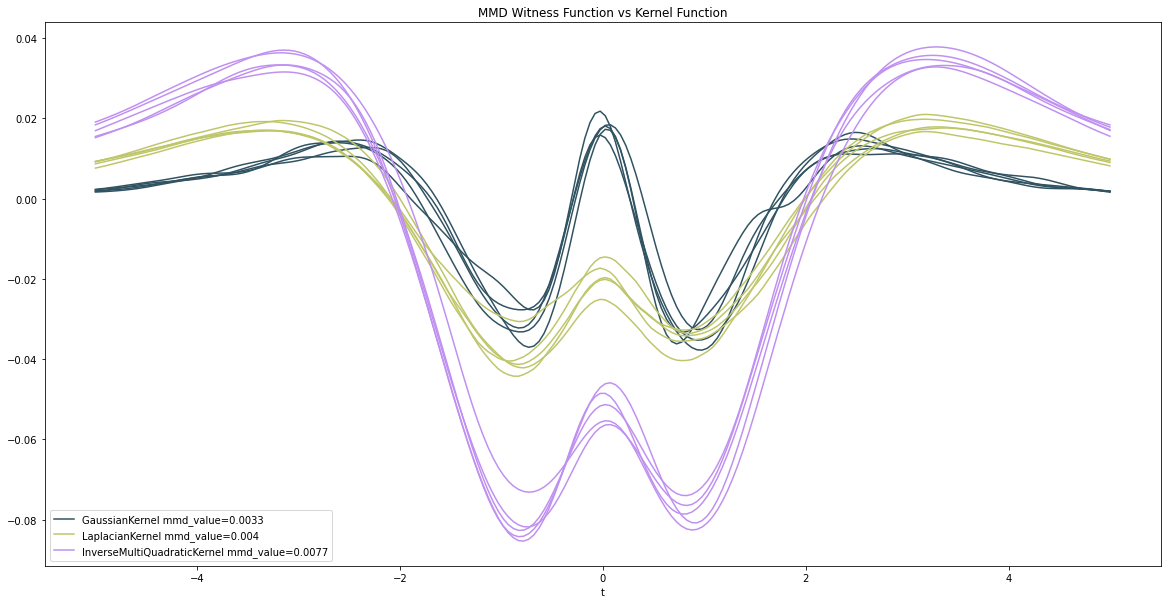

In [13]:
n_trials = 5
sigmas = np.logspace(-3, 3, 5)
fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(10)
n_sample = int(1e4)
t = np.linspace(-5, 5, 200)
kernels = [
    GaussianKernel(sigma=10),
    LaplacianKernel(sigma=1),
    InverseMultiQuadraticKernel(c=0.5, beta=-0.5),
]
for i, kernel in enumerate(kernels):
    mmd = MaximumMeanDiscrepancy(kernel=kernel)
    c = np.random.rand(
        3,
    )
    for j in range(n_trials):
        witness_values = mmd.witness_function(
            x=np.random.laplace(loc=0.0, scale=1.0, size=n_sample).reshape(-1, 1),
            y=np.random.normal(loc=0.0, scale=1.0, size=n_sample).reshape(-1, 1),
            t=t,
        )
        if j == 0:
            mmd_value = np.round(float(mmd.compute(x, y)), 4)
            plt.plot(
                t, witness_values, c=c, label=f"{type(kernel).__name__} {mmd_value=}"
            )
        else:
            plt.plot(t, witness_values, c=c)
plt.title("MMD Witness Function vs Kernel Function")
plt.xlabel("t")
plt.legend()
plt.show()

We can also plot the witness function between samples of MNIST. This is a bit more tricky because the images have 784 pixels and thus are viewed to be generated from 784 dimensional distributions. This then results in a 784 dimensional witness function. Below we visualise the witness function by tracing the path of this function along a subset of these dimensions.

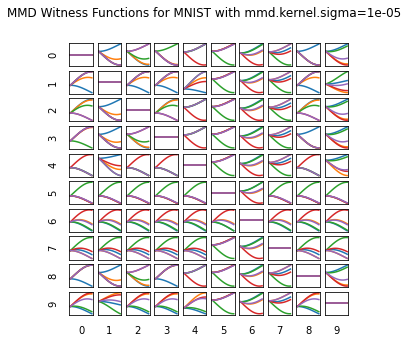

In [14]:
x = np.array(mnist.data)
y = mnist.target
n_t = 50
num_random_pixels = 5

random_pixels = np.argsort(np.std(x, axis=0))[-num_random_pixels:]

t = np.zeros((num_random_pixels, n_t, 784))
for i, random_pixel in enumerate(random_pixels):
    t[i, :, random_pixel] = np.linspace(0, 255, n_t)
mnist_mmd_witness_function_gauss = np.zeros((10, 10, num_random_pixels, n_t))
n_samples = 2
sigma = 1e-5
mmd = MaximumMeanDiscrepancy(kernel=GaussianKernel(sigma))
for i in range(10):
    a = x[y == str(i)][:n_samples]
    for j in range(10):
        if i == j:
            b = x[y == str(j)][n_samples : 2 * n_samples]
        else:
            b = x[y == str(j)][:n_samples]
            for k in range(num_random_pixels):
                mnist_mmd_witness_function_gauss[i, j, k, :] = mmd.witness_function(
                    a, b, t[k, :, :]
                )
fig, axs = plt.subplots(10, 10)
fig.set_figwidth(5)
fig.set_figheight(5)
for i in range(10):
    for j in range(10):
        for k in range(num_random_pixels):
            axs[i][j].plot(mnist_mmd_witness_function_gauss[i, j, k, :])
            axs[i][j].tick_params(
                axis="x",
                which="both",
                bottom=False,
                top=False,
            )
            axs[i][j].tick_params(
                axis="y",
                which="both",
                left=False,
                right=False,
            )
            axs[i][j].xaxis.set_ticklabels([])
            axs[i][j].yaxis.set_ticklabels([])
            axs[i][j].set_xlabel(j)
            if j == 0:
                axs[i][j].set_ylabel(i)
fig.suptitle(f"MMD Witness Functions for MNIST with {mmd.kernel.sigma=}")
plt.show()

We can see that along the diagonal, the witness functions are all flat. This makes sense as the x and y samples are from the same digit. But for all other plots, we can see witness functions for the different pixels.

If we choose a larger sigma and generate the same plots, we can see that the witness function is no longer able to pick up the discrepancies between the digits. All the witness functions are flat lines. This shows the importance of choosing an appropriate kernel function.

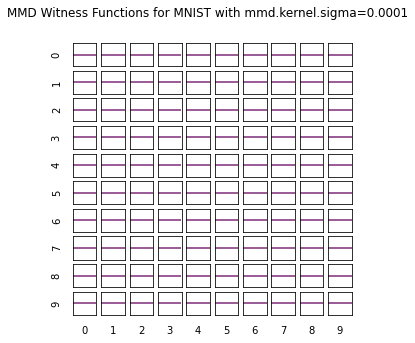

In [15]:
sigma = 1e-4
mmd = MaximumMeanDiscrepancy(kernel=GaussianKernel(sigma))
for i in range(10):
    a = x[y == str(i)][:n_samples]
    for j in range(10):
        if i == j:
            b = x[y == str(j)][n_samples : 2 * n_samples]
        else:
            b = x[y == str(j)][:n_samples]
            for k in range(num_random_pixels):
                mnist_mmd_witness_function_gauss[i, j, k, :] = mmd.witness_function(
                    a, b, t[k, :, :]
                )
fig, axs = plt.subplots(10, 10)
fig.set_figwidth(5)
fig.set_figheight(5)
for i in range(10):
    for j in range(10):
        for k in range(num_random_pixels):
            axs[i][j].plot(mnist_mmd_witness_function_gauss[i, j, k, :])
            axs[i][j].tick_params(
                axis="x",
                which="both",
                bottom=False,
                top=False,
            )
            axs[i][j].tick_params(
                axis="y",
                which="both",
                left=False,
                right=False,
            )
            axs[i][j].xaxis.set_ticklabels([])
            axs[i][j].yaxis.set_ticklabels([])
            axs[i][j].set_xlabel(j)
            if j == 0:
                axs[i][j].set_ylabel(i)
fig.suptitle(f"MMD Witness Functions for MNIST with {mmd.kernel.sigma=}")
plt.show()